In [1]:
!pip install catboost
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.8/101.7 MB 907.1 kB/s eta 0:01:52
    --------------------------------------- 1.3/101.7 MB 1.4 MB/s eta 0:01:11
    --------------------------------------- 1.8/101.7 MB 1.6 MB/s eta 0:01:02
    --------------------------------------- 2.4/101.7 MB 1.8 MB/s eta 0:00:57
   - -------------------------------------- 3.1/101.7 MB 2.0 MB/s eta 0:00:50
   - -------------------------------------- 3.7/101.7 MB 2.1 MB/s eta 0:00:48
   - -------------------------------------- 4.2/101.7 MB 2.2 MB/s eta 0:00:46
   - --------------

In [3]:
import pandas as pd
df = pd.read_csv(r"C:\Users\roxna\Desktop\Churn_Analysis\WA_Fn-UseC_-Telco-Customer-Churn.csv")

print("no. of churned customer : " )
print(df[df['Churn']=='Yes'].value_counts().sum())
print("\nno. of satisfied customer : " )
print(df[df['Churn']=='No'].value_counts().sum())

print("\ntotal consumers : ")
print(df.shape[0])

no. of churned customer : 
1869

no. of satisfied customer : 
5174

total consumers : 
7043


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
print(df.sample(5))

      customerID gender  SeniorCitizen Partner Dependents  tenure  \
6825  5022-KVDQT   Male              0      No         No      27   
2660  5639-NTUPK   Male              0      No        Yes      13   
4308  7504-UWHNB   Male              0      No         No      25   
6224  2330-PQGDQ   Male              0     Yes        Yes      51   
5974  7094-MSZAO   Male              0     Yes        Yes      10   

     PhoneService MultipleLines InternetService       OnlineSecurity  ...  \
6825          Yes           Yes     Fiber optic                   No  ...   
2660          Yes            No             DSL                  Yes  ...   
4308          Yes            No     Fiber optic                   No  ...   
6224          Yes           Yes     Fiber optic                   No  ...   
5974          Yes            No              No  No internet service  ...   

         DeviceProtection          TechSupport          StreamingTV  \
6825                  Yes                   No     

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, precision_score, roc_auc_score, f1_score, recall_score, roc_curve, auc, balanced_accuracy_score)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

C:\Users\roxna\AppData\Local\Temp\ipykernel_33680\156400559.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)


In [13]:
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')
df = df.replace('No internet service', 'No')

internet_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# df = df.replace({'Yes': 1, 'No': 0})....................reduces accuracy maybe alters column which is not needed to be altered.
columns = ["Partner","Dependents","PhoneService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies", "PaperlessBilling", "Churn" ]
for i in columns:
  df[i] = df[i].map({'Yes': 1, 'No': 0})

In [15]:
binary_columns = ['gender']
le = LabelEncoder()
df[binary_columns] = df[binary_columns].apply(le.fit_transform)
df = pd.get_dummies(df, columns=['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod'])

scaler = StandardScaler()
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [17]:
X = df.drop('Churn', axis=1)
y = df['Churn']
smote = SMOTE(random_state=50)
X_res, y_res = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=48) #42 #48 - 0.8555555555555555    

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [26]:
models = [('Logistice Regression', LogisticRegression(random_state=123456)),
          ('K-nearest Neighbours', KNeighborsClassifier()),
          ('Decision Tree', DecisionTreeClassifier(random_state=123456)),
          ('Random Forest', RandomForestClassifier(random_state=123456)),
          ('Support Vector Machine', SVC(gamma='auto',random_state=123456)),
          ('Gradient Boosting', GradientBoostingClassifier(random_state = 12345))          ]
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=123456, shuffle = True)
    cv_results = cross_val_score(model, X, y, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy = %f " % (name, cv_results.mean())
    print(msg)

Logistice Regression: Accuracy = 0.804913 
K-nearest Neighbours: Accuracy = 0.765582 
Decision Tree: Accuracy = 0.723408 
Random Forest: Accuracy = 0.793834 
Support Vector Machine: Accuracy = 0.798522 
Gradient Boosting: Accuracy = 0.802780 


In [28]:
catboost_model = CatBoostClassifier(iterations=1000, depth=9, learning_rate=0.11, loss_function='Logloss', verbose=0)
catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of CatBoost Model after SMOTE:", accuracy)

Accuracy of CatBoost Model after SMOTE: 0.8565217391304348


In [30]:
model = RandomForestClassifier(random_state=52)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred)}")

# .........................................................................................................

gb_model = GradientBoostingClassifier(learning_rate = 0.1, random_state = 50, n_estimators = 200, min_samples_split = 6, max_depth = 7)
gb_model.fit(X_train, y_train)
gb_y_pred = gb_model.predict(X_test)
print(f"Gradient boosting Accuracy: {accuracy_score(y_test, gb_y_pred)}")

# .........................................................................................................

xgb_model = XGBClassifier(learning_rate=0.1, random_state=100, n_estimators=100, subsample=0.8, max_depth=9)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_y_pred)}")

Random Forest Accuracy: 0.8531400966183574
Gradient boosting Accuracy: 0.8541062801932368
XGBoost Accuracy: 0.8507246376811595


In [32]:
catboost_model = CatBoostClassifier(iterations=1000, depth=9, learning_rate=0.11, loss_function='Logloss', verbose=0)
catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
classification_report = classification_report(y_test, y_pred)
print("CatBoost Model result:\n", classification_report)

CatBoost Model result:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       976
           1       0.86      0.87      0.86      1094

    accuracy                           0.86      2070
   macro avg       0.86      0.86      0.86      2070
weighted avg       0.86      0.86      0.86      2070



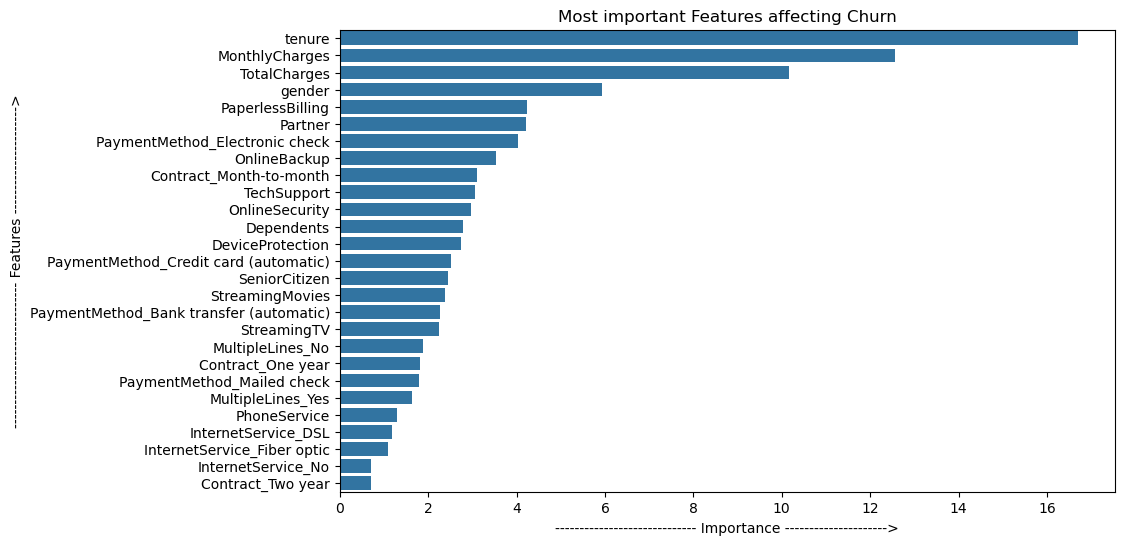

In [34]:
feature_importances = catboost_model.get_feature_importance()
features = X_train.columns

importance_df = pd.DataFrame({
    'Features': features,
    'Importance': feature_importances })
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Features', data=importance_df)
plt.title('Most important Features affecting Churn')
plt.xlabel('----------------------------- Importance --------------------->')
plt.ylabel('------------------------------ Features ---------------------->')
plt.show()

In [36]:
def create_customer_profiles(X):
    return X


def get_similar_customers(customer_profiles, target_customer_idx, n=5):
    similarity_matrix = cosine_similarity(customer_profiles)
    similar_indices = similarity_matrix[target_customer_idx].argsort()[::-1][1:n+1]
    return similar_indices

In [40]:
def generate_recommendations(X, y, customer_profiles, target_customer_idx):
    similar_customers = get_similar_customers(customer_profiles, target_customer_idx)
    non_churned_similar = [idx for idx in similar_customers if y[idx] == 0]

    if not non_churned_similar:
        return None
    current_customer = X.iloc[target_customer_idx]
    similar_customers_data = X.iloc[non_churned_similar]

    recommendations = {}
    # ...........................Recommendation based on Contract period...............................
    contract_columns = [col for col in X.columns if 'Contract_' in col]
    current_contract = [col for col in contract_columns if current_customer[col] == 1][0].split('_')[1]
    avg_contract_usage = similar_customers_data[contract_columns].mean()
    recommended_contract = avg_contract_usage.idxmax().split('_')[1]

    if current_contract == 'Month-to-month':
        recommendations['Contract'] = "Consider offering a discounted long-term contract"

    #............................Recommendation based on Internet services used.........................
    internet_columns = [col for col in X.columns if 'InternetService_' in col]
    current_internet = [col for col in internet_columns if current_customer[col] == 1]
    current_internet = current_internet[0].split('_')[1] if current_internet else 'None'

    if current_internet == 'DSL':
        recommendations['InternetService'] = "Upgrade to Fiber optic service with a special promotion"
    elif current_internet == 'None':
        recommendations['InternetService'] = "Introduce internet service with a first-time customer discount"

    # ............................Recommendations based on other Additional services....................
    if current_customer['OnlineSecurity'] == 0:
        recommendations['OnlineSecurity'] = "Add online security features to the package"
    if current_customer['TechSupport'] == 0:
        recommendations['TechSupport'] = "Include premium technical support"
    if current_customer['DeviceProtection'] == 0:
        recommendations['DeviceProtection'] = "Add device protection plan"
    if current_customer['OnlineBackup'] == 0:
        recommendations['OnlineBackup'] = "Include online backup service"
    if current_customer['StreamingTV'] == 0 & current_customer['StreamingMovies'] == 0:
        recommendations['StreamingTV'] = "Suggest TV & Movies streaming services at discounted prices"
    return recommendations

In [42]:
def get_customer_insights(customer_id, X, y, catboost_model):
    if customer_id < 0 or customer_id >= len(X):
        return " !!! Invalid customer ID !!! "

    churn_prob = catboost_model.predict_proba(X.iloc[customer_id:customer_id+1])[0][1]
    customer_data = X.iloc[customer_id]

    customer_profiles = create_customer_profiles(X)
    recommendations = generate_recommendations(X, y, customer_profiles, customer_id)
    return {
        'churn_probability': churn_prob,
        'current_services': parse_current_services(customer_data),
        'recommendations': recommendations if recommendations else {}
    }

def parse_current_services(customer_data):
    services = {}
    # Contract type
    contract_cols = [col for col in customer_data.index if 'Contract_' in col]
    for col in contract_cols:
        if customer_data[col] == 1:
            services['Contract'] = col.split('_')[1]

    # Internet service
    internet_cols = [col for col in customer_data.index if 'InternetService_' in col]
    for col in internet_cols:
        if customer_data[col] == 1:
            services['InternetService'] = col.split('_')[1]

    # Additional services
    service_map = {
        'OnlineSecurity': 'Online Security',
        'OnlineBackup': 'Online Backup',
        'DeviceProtection': 'Device Protection',
        'TechSupport': 'Tech Support',
        'StreamingTV': 'Streaming TV',
        'StreamingMovies': 'Streaming Movies'    }

    services['AdditionalServices'] = [readable for service, readable in service_map.items()
                                     if customer_data[service] == 1]
    return services

In [44]:
def interactive_customer_recommendations():
    while True:
        try:
            customer_id = int(input("\nEnter customer ID (between 1 to 7043 or (-1) to exit): "))
            if customer_id == -1:
                print("Exiting recommender system...")
                print("Thank you for using our services")
                break

            insights = get_customer_insights(customer_id, X_res, y_res, catboost_model)
            if isinstance(insights, str):
                print(insights)
                continue
            print(f"\nCustomer {customer_id} Analysis")
            print("-" * 20)

#.................................Churn risk category........................................
            churn_prob = insights['churn_probability']
            if churn_prob < 0.3:
                risk_category = "Low Risk"
            elif churn_prob < 0.6:
                risk_category = "Medium Risk"
            else:
                risk_category = "High Risk"
            print(f"Costumer Churn Risk: {risk_category} ({churn_prob:.1%} probability)")

#....................................Current services..........................................
            print("\nCurrent Services:")
            current = insights['current_services']
            print(f"Contract Type: {current['Contract']}")
            print(f"Internet Service: {current.get('InternetService', 'None')}")
            if current['AdditionalServices']:
                print("Additional Services:", ", ".join(current['AdditionalServices']))
            else:
                print("Additional Services: None")

            if insights['recommendations']:
                print("\nRecommendations to Prevent Churn:")
                for category, recommendation in insights['recommendations'].items():
                    print(f"- {recommendation}")
            else:
                print("\nNo specific recommendations at this time.")

        except ValueError:
            print("enter valid customer ID (numeric value)")

print("Welcome to the Customer Churn Prevention System")
print("This system will provide personalized recommendations to prevent customer churn.")
interactive_customer_recommendations()

Welcome to the Customer Churn Prevention System
This system will provide personalized recommendations to prevent customer churn.



Enter customer ID (between 1 to 7043 or (-1) to exit):  1701



Customer 1701 Analysis
--------------------
Costumer Churn Risk: High Risk (85.8% probability)

Current Services:
Contract Type: One year
Internet Service: Fiber optic
Additional Services: Online Backup, Device Protection, Streaming TV, Streaming Movies

Recommendations to Prevent Churn:
- Add online security features to the package
- Include premium technical support



Enter customer ID (between 1 to 7043 or (-1) to exit):  613



Customer 613 Analysis
--------------------
Costumer Churn Risk: Low Risk (5.5% probability)

Current Services:
Contract Type: One year
Internet Service: Fiber optic
Additional Services: Online Security, Online Backup, Device Protection, Streaming TV, Streaming Movies

Recommendations to Prevent Churn:
- Include premium technical support



Enter customer ID (between 1 to 7043 or (-1) to exit):  38



Customer 38 Analysis
--------------------
Costumer Churn Risk: High Risk (97.4% probability)

Current Services:
Contract Type: Month-to-month
Internet Service: Fiber optic
Additional Services: Online Backup, Device Protection, Streaming TV, Streaming Movies

No specific recommendations at this time.



Enter customer ID (between 1 to 7043 or (-1) to exit):  3942



Customer 3942 Analysis
--------------------
Costumer Churn Risk: High Risk (87.8% probability)

Current Services:
Contract Type: Month-to-month
Internet Service: DSL
Additional Services: None

Recommendations to Prevent Churn:
- Consider offering a discounted long-term contract
- Upgrade to Fiber optic service with a special promotion
- Add online security features to the package
- Include premium technical support
- Add device protection plan
- Include online backup service
- Suggest TV & Movies streaming services at discounted prices



Enter customer ID (between 1 to 7043 or (-1) to exit):  -1


Exiting recommender system...
Thank you for using our services
